# Vit Paper replication
#### by David Vikstrand (2022)


Welcome to my ViT Paper replication documentation, In this notebook, I will do a replication of the ViT Paper released in 2021
called:


***AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE***


You can find the paper at this [link](https://arxiv.org/pdf/2010.11929.pdf)


I will first do a simple breakdown of the paper and then recreate the different steps from scratch using PyTorch.
Let's do this!

### Summation of the ViT Paper


The ViT (Vision Transformer) is a model architecture for image classification. While the most common model architecture in
Computer vision (CV) is Convolutional neural network (CNN),
The ViT model is completely independent of CNN and uses a different classification method.


The ViT architecture is inspired by a paper from 2017 called "Attention is all you need." This is a paper on
Natural language processing (NLP) and describes a model architecture for NLP based on self-attention. Since then, the self-attention
technique have become de-facto standard for NLP,


In CV, self-attention-based architectures are still fairly unexplored, with just some previous attempts to utilize part of the technique in
conjunction with a convolutional network. the "An Image is Worth 16x16 Words" paper wanted to stay as close as possible to the 'Attention is all you need' model architecture and exploring it in CV.


In this documentation, I will walk you through the entire process of creating the ViT model, showing you how each component is created and how it works.

### A quick overview of the ViT model structure


This is an image from the ViT paper showcasing a simplified map of the model architecture.  


The first step is to split the image into small patches; this is done by splitting the image into 14 or 16 small patches (the image example is 9).

![alt text](https://miro.medium.com/max/1400/1*l37va2Mu8Snx6LLb13430A.png "ViT map")

### Introduction to patching the image
I will start with a pseudo-patching of the image using the same CNN method as the real patching technique, but in this example, I will not 
adapt the patch embedding and just focus on how the different patches are being created.

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from going_modular import data_setup, engine, utils

try:
  from torchinfo import summary
except:
  !pip install -q torchinfo
  from torchinfo import summary

### Get the data
Here, I download the data and turn it into dataloaders.
For this example, I use a downsized 'Food101' dataset only containing the pizza, steak, and sushi images. In my documentation, I will use
batch size of 32.

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

image_path = utils.download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',
                                 destination='pizza_steak_sushi')

train_dir = image_path / 'train'
test_dir = image_path / 'test'

IMG_SIZE = 224
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]

### Example of one image in the dataset

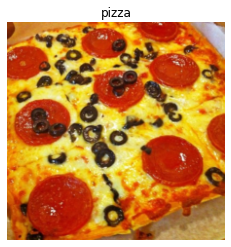

In [3]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

# Part 1: Patch Embeddings

### Pseudo-patching example
Here is a patched version of the image; it has 196 patches with a dimension of 16x16. This is just an example of the number of patches.
and patching size, it is not a visual representation of how the image will look once it is patched, as you will see.

Number of patches per row: 14        
Number of patches per column: 14        
Total patches: 196        
Patch size: 16 pixels x 16 pixels


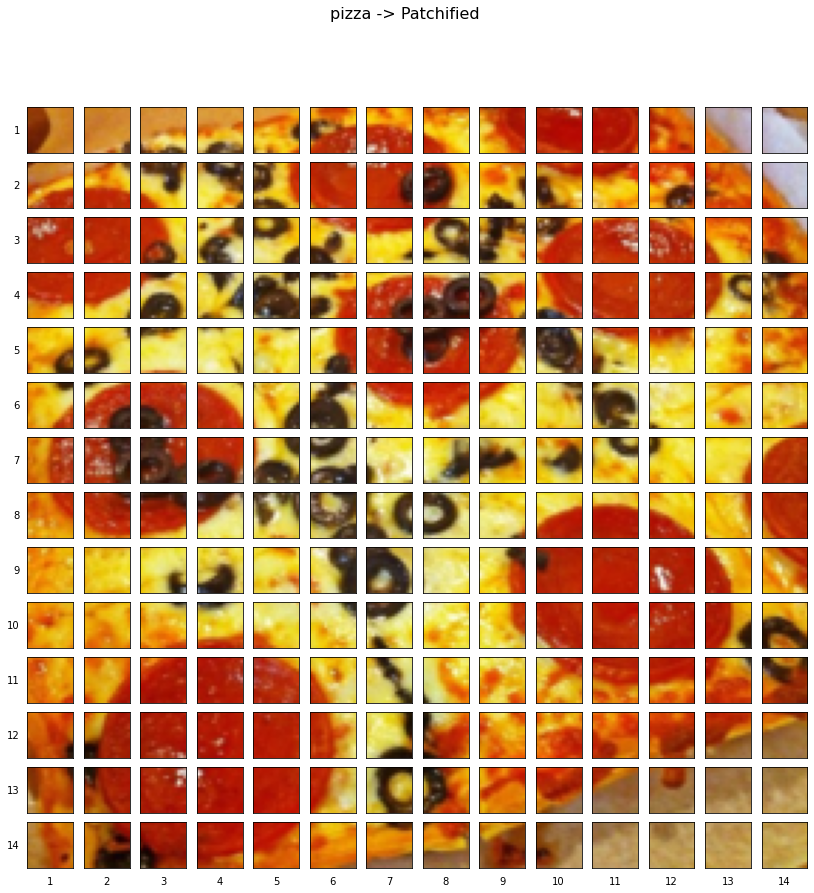

In [4]:
image_permuted = image.permute(1,2,0)
img_size = 224
patch_size = 16
num_patches = img_size//patch_size
assert img_size % patch_size == 0, 'Image size must be divisible by patch size'
print(f'Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels')

fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)



for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):

        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, 
                                        patch_width:patch_width+patch_size,
                                        :]);
         # keep height index constant, alter the width index
            
        axs[i, j].set_ylabel(i+1,
                             rotation='horizontal',
                             horizontalalignment='right',
                             verticalalignment='center')
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

fig.suptitle(f'{class_names[label]} -> Patchified', fontsize=16)
plt.show()

### Patching Logic
The original size of the image is 224x224 with 3 color channels. In this example, I will use
16 pixels as patch sizes and create 196 patches (16x16x196=224x224).


In this example, the image is manually split into patches, and the image's original pixel values stay the same.
This is not the case for the ViT model; the model uses a CNN layer to split the images into patches.
It does so by setting the kernel and stride size to the patch size and then cropping 196 non-overlapping patches.


In my example image, each patch still represents the pixel values of the original image, and you can still clearly see the original image.
This is also not the case for the ViT model; since it uses a kernel to patch the image, each patch will only get one single value based on the CNN layer.

### Create an image patching of the original image.


Here I create a Conv2d layer with a kernel and stride size of 16, which will create the patching effect.
I also test-run the original image through the layer to visualize the patching.

In [5]:
patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

image_out_of_conv = conv2d(image.unsqueeze(0))

print(f'Original image shape: {image.shape}')
print(f'Image shape after Convulotion layer: {image_out_of_conv.shape}')
print('\tConvulotion layer: [(batch_size, embedding_dim, feature_map_height, feature_map_width)]')

Original image shape: torch.Size([3, 224, 224])
Image shape after Convulotion layer: torch.Size([1, 768, 14, 14])
	Convulotion layer: [(batch_size, embedding_dim, feature_map_height, feature_map_width)]


As you can see, the shape of the output torch has changed pretty drastically. From an input shape of [3, 244, 244]
( color channels, image height, image width), to an output shape of [1, 768, 14, 14]. You may want to interpret this new shape as
(batch_size, color channels, image height, image width) as in the input shape, but this is not correct. The number 768
is a value that the ViT paper refers to as D or 'hidden size D'. This constant has different values depending on
which ViT model you are using.


Since my documentation focuses on ViT-Base, the value for D will be 768 and it will be the output shape
for the convolution layer (3x244x244=768x14x14).


This creates 768 interpretations of the image, each with a height and width of 14, referred to as a feature map.
That means that the new shape from the convolution layer is (batch size, hidden size D, feature map height, feature map width).

Here's an example of two of the 768 feature maps created by the convolution layer. The original image is barely visible between these two, but if you look closely enough, you will see some similarities.

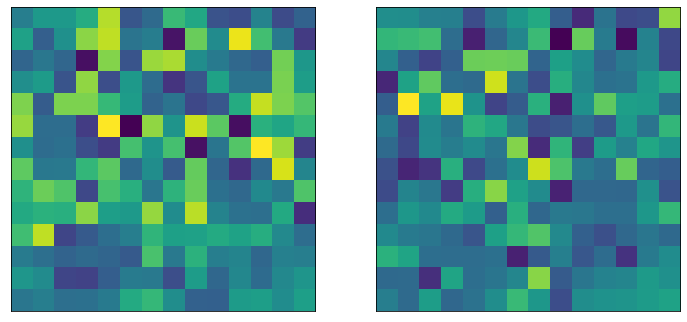

In [6]:
import random 
random_indexes = random.sample(range(0, 768), k=2)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

### Flatten the feature maps


The next step is to flatten the feature maps;
 Since that model from "Attention is all you need." was made for NLP, it's natural to have a one-dimensional input since words operate in 
one-dimensional space. 


From now on, I will refer to value D (768) as "embedding size."

In [7]:
flatten = nn.Flatten(start_dim=2,
                     end_dim=3)

print(f'Original image shape: {image.shape}')

image_out_of_conv = conv2d(image.unsqueeze(0))
print(f'Image feature map shape: {image_out_of_conv.shape}')

image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f'Flattened image feature map shape: {image_out_of_conv_flattened.shape}')

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


The new flattened shape is now [1, 768, 196] (embedding size, num patches), but we also need to make some adjustments to this current shape.
Since the model wants to be fed with patch values, we need to group the different feature map patch values together.
We can do this by changing the current shape to (batch size, number of patches, embedding size). That way we can pass all the 768 different 
values for a specific patch at once to the model.

In [8]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0,2,1)
print(f'Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_shape]')

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_shape]


Great! Now the shape looks as it should.
Here is an example of a flattened feature map; it is now almost impossible for a human to recognize the original image.

torch.Size([1, 196])


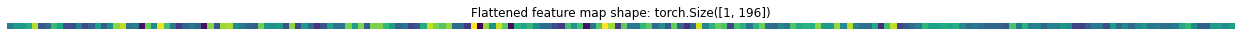

In [9]:
single_out_of_conv_flattened_reshaped = image_out_of_conv_flattened_reshaped[:,:,0]

plt.figure(figsize=(22, 1))
plt.imshow(single_out_of_conv_flattened_reshaped.detach().numpy())
plt.title(f'Flattened feature map shape: {single_out_of_conv_flattened_reshaped.shape}')

plt.axis(False);
print(single_out_of_conv_flattened_reshaped.shape)

Here are all the embeddings stacked together for a more literal visual representation of what the model will receive (even though 
we are going to modify this input a bit more.)

<Figure size 432x288 with 0 Axes>

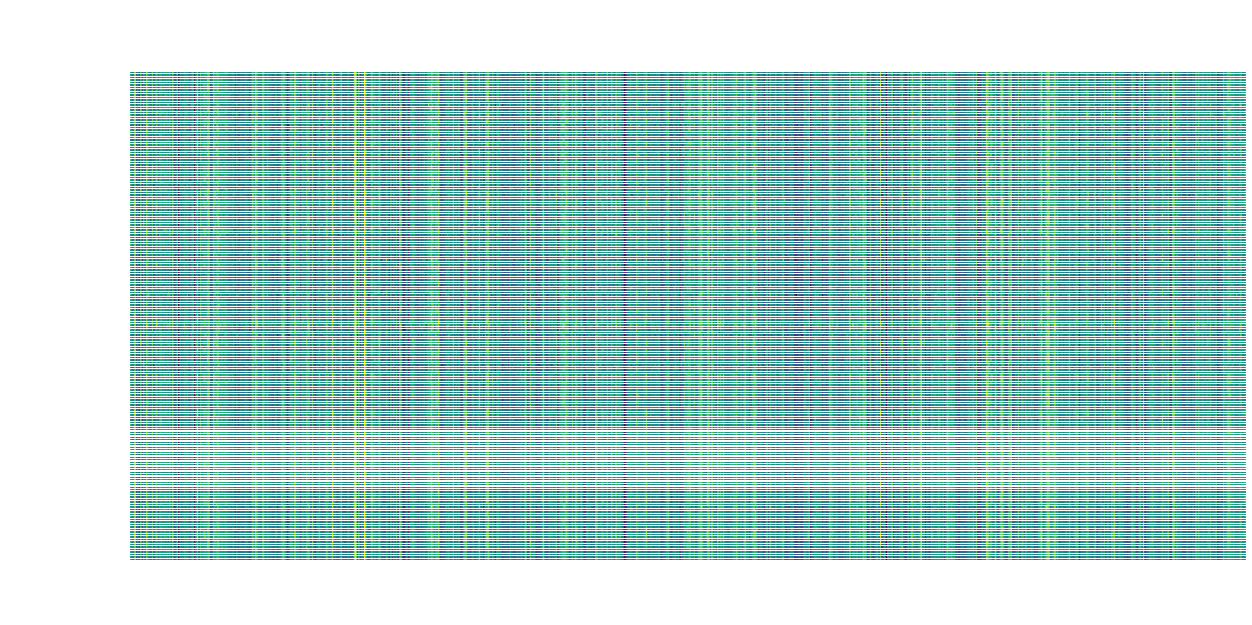

In [72]:
t = 196

plt.figure()
fig, axs = plt.subplots(t,1, sharex=True, sharey=True, figsize=(20, 9))
fig.text(0.5, 0.04, 'Representing the embeddings (768)', ha='center')
fig.text(0.04, 0.5, 'Representing the different patches (196)', va='center', rotation='vertical')
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

for i in range(t):
    a = image_out_of_conv_flattened_reshaped[:,i,:]
    axs[i].imshow(a.detach().numpy());
    axs[i].axis(False);
    
fig.suptitle(f'image conv & flat stacked for {t} iterations of 768', fontsize=16)
plt.show();

### Creating a Patch Embedding Module


It's now time to put all the previous steps together to make it quick and easy to create these path embeddings.
So I take all the steps we've gone through and put them in a nn.Module Class.

In [11]:
class PatchEmbedding(nn.Module):
    """ Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels fot the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768 """
    
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        self.patch_size=patch_size

        self.patcher = nn.Conv2d(in_channels=in_channels,
                       out_channels=embedding_dim,
                       kernel_size=patch_size,
                       stride=patch_size,
                       padding=0)
        
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)
    
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0,\
                    f'Input image size must be divisible by patch size, '\
                    f'image shape: {image_resolution}, patch size: {patch_size}'
        
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        
        return x_flattened.permute(0,2,1)
        

Let's pass our original image through the PatchEmbedding layer to create the right shape and form!

In [12]:

utils.set_seeds()

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f'Input image shape: {image.unsqueeze(0).shape}')
patch_embedded_image = patchify(image.unsqueeze(0))
print(f'Output patch embedding shape: {patch_embedded_image.shape}')

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


Great!


Here is a brief summary of the PatchEmbedding layer we created.

In [13]:
summary(PatchEmbedding(),
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

![alt text](https://miro.medium.com/max/1400/1*l37va2Mu8Snx6LLb13430A.png "ViT map")

### Adding the class embedding


As we can see in the image above, there is a patch with the number "0" called "Extra learnable [class] embedding."
This is an extra embedding layer that gets concatenated on top of the other embeddings. As the ViT paper states, "In order
to perform classification, we use the standard approach of adding an extra learnable "classification token" to the sequence". The class
embedding is initialized with random values and will be updated later when the model is trained.


So let's add the class embedding.


In this example, I will not use random values for the class embedding but instead use just value one. This is for demonstration purposes.
to make it easier to understand what happens when we later add the position embedding.

In [14]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.ones(1,1,embedding_dimension),
                                        requires_grad=True)


patch_embedded_image_w_class_embedding = torch.cat((class_token,
                                                    patch_embedded_image)
                                                   ,dim=1)


print(f'Class token shape: {class_token.shape} ->'\
                      '[batch_size, number_of_tokens, embedding_dimension]')

print(f'Sequence of patch embeddings with class token shape: '\
                              '{patch_embedded_image_w_class_embedding.shape}')

Class token shape: torch.Size([1, 1, 768]) ->[batch_size, number_of_tokens, embedding_dimension]
Sequence of patch embeddings with class token shape: {patch_embedded_image_w_class_embedding.shape}


As we can see, we gained one extra patch size from our original shape [1, 196, 768] to [1, 197, 768] by adding the class embedding.

### Adding the position embedding


The image also shows us that each patch holds a "position embedding." This is just a learnable embedding that gets added to
each embedding. This position embedding is also initialized with random values and will be modified later when the model is trained.
This protects the model from overfitting and helps it retain positional information. The ViT paper also states:


"Position embeddings are added to the patch embeddings to retain positional information. We use
standard learnable 1D position embeddings, since we have not observed significant performance
gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting
sequence of embedding vectors serves as input to the encoder."


"the position embeddings at initialization time carry no information
about the 2D positions of the patches and all spatial relations between the patches have to be learned
from scratch."


Just like with the class embedding, I will not use random values for the position embedding but instead use value one. This is just to make a clearer example for this demonstration, but later on I will use random values.



In [15]:
num_patches = patch_embedded_image_w_class_embedding.shape[1]

position_embedding = nn.Parameter(torch.ones(1,
                                             num_patches,
                                             embedding_dimension),
                                             requires_grad=True)

print(f'position embedding shape: {position_embedding.shape} -> '\
                      '[batch_size, number_of_patches, embedding_dimension]')

position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Now we have our position embedding with the matching shape as our transformed image, except it doesn't have a batch size: ([1, 197, 768]).


Our next step is to add the position embedding to our transformed image and get all the position embedding values added to the patch embedding
values. We can do this by just adding these two together.



In [16]:
patch_and_position_embedding = patch_embedded_image_w_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f'Patch embddings, class token prepended and positional embeddings added added shape: {patch_and_position_embedding.shape}')

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.4784, 1.1157, 1.0208,  ..., 1.3766, 0.6803, 0.9670],
         [0.4467, 1.1467, 0.8609,  ..., 1.3843, 0.6649, 1.2536],
         ...,
         [0.3722, 1.1604, 0.8380,  ..., 1.4092, 0.7194, 1.2681],
         [0.3768, 1.1318, 0.8387,  ..., 1.4356, 0.6397, 1.2891],
         [0.3209, 1.1456, 0.8337,  ..., 1.4787, 0.6436, 1.2471]]],
       grad_fn=<AddBackward0>)
Patch embddings, class token prepended and positional embeddings added added shape: torch.Size([1, 197, 768])


Look at that! The positional embeddings are now added to the patch embeddings. As you can see, the first embedding is called the class
embedding are all values of two. This is because in the example above, I initialized both the positional and class embedding with ones,
and as a result of adding them together, it now adds up to two. 

All the other patch embeddings have also increased by one from the
positional embedding. Later, when we create a module that contains all these steps, we will not use value one to initialize these embeddings
but instead use random values.

In [17]:
utils.set_seeds()

patch_size = 16

print(f'Image tensor shape: {image.shape}')

height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)

print(f'Input image with batch dimension shape: {x.shape}')

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

patch_embedding = patch_embedding_layer(x)

print(f'Patching embedding shape: {patch_embedding.shape}')

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)

print(f'Class token embedding shape: {class_token.shape}')

patch_embedding_class_token = torch.cat((class_token,
                                         patch_embedding)
                                        ,dim=1)

print(f'Patching embedding with class token embedding shape: {patch_embedding_class_token.shape}')

number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding

print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')
patch_and_position_embedding

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patching embedding with class token embedding shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.4784, 1.1157, 1.0208,  ..., 1.3766, 0.6803, 0.9670],
         [0.4467, 1.1467, 0.8609,  ..., 1.3843, 0.6649, 1.2536],
         ...,
         [0.3722, 1.1604, 0.8380,  ..., 1.4092, 0.7194, 1.2681],
         [0.3768, 1.1318, 0.8387,  ..., 1.4356, 0.6397, 1.2891],
         [0.3209, 1.1456, 0.8337,  ..., 1.4787, 0.6436, 1.2471]]],
       grad_fn=<AddBackward0>)

That's all we need to do for the patch embedding, now let's start with the transformer block!

# Part 2: the Transformer Encoder

![alt text](https://miro.medium.com/max/1400/1*l37va2Mu8Snx6LLb13430A.png "ViT map")

### Transformer block logic


The picture above shows us that the Transformer encoder consists of alternating layers of multi-headed self-
attention (MSA) and MLP blocks. Layernorm (LN) is applied before
every block, and residual connections after every block. The MLP contains two layers with GELU non-linearity.


Information about the different blocks:


![alt text](https://velog.velcdn.com/images%2Fmkcl88%2Fpost%2F4586dcec-282e-4263-9452-f369831a75ff%2Fimage.png "ViT info")


Information about the different parameters:


![alt text](https://miro.medium.com/max/1400/1*xQeRA3fJln4pg2vDpxYP9w.png "ViT info")


Since this documentation focuses on ViT-Base our MSA is going to have 12 heads, and the MLP size will be 3072

### Multi-head Self-Attention 
In this first block called "Multi-head Self-Attention,"  we first pass the patch embeddings to a layer normalization and then to
a multi-headed self-attention layer. The ViT paper
uses dropout values of 0.0 and 0.1 when training. 

In [18]:
class MultiheadSelfAttentionBlock(nn.Module):
    """ MSA block, first half of transformer block """
    
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:int=0):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [19]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12)

patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f'Input shape of MSA block: {patch_and_position_embedding.shape}')
print(f'Output shape of MSA block: {patched_image_through_msa_block.shape}')

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


We can observe that this first block doesn't change our shape, which is still at  [1, 197, 768]

### Multi-layer Perception block


We can find in the ViT paper that "The MLP contains two layers with a GELU non-linearity." The two layers refer to linear layers,
and "GELU non-linearity" is the GELU activation function. We also know that dropout is applied after
every dense layer. The MLP size is 3072, the values for dropout is 0.1.


The MLP block has a similar structure to the MSA block, the input is first passed to a layer normalization and then to the MLP layer.



In [20]:
class MLPBlock(nn.Module):
    """ MPL block, first half of transformer block """
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:int=0.1):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    
    def forward(self, x):
            x = self.layer_norm(x)
            x = self.mlp(x)
            return x

In [21]:
mlp_block = MLPBlock(embedding_dim=768,
             mlp_size=3072,
             dropout=0.1)


patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f'Input shape of MLP block: {patched_image_through_msa_block.shape}')
print(f'Output shape of MLP block: {patched_image_through_mlp_block.shape}')

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


The shape of the output still stays at [1, 197, 768]

### Transformer Encoder Block
It's now time to put all the pieces together and create the Transformer Encoder Block. To do this, we can create a TransformerEncoderBlock
class that inherits from nn.Module. Here, we need to pass our path embedding to the MSA block and create a residual connection to the output.
Than we pass this combined output directly to the MLP block and create a residual connection to the output.

In [22]:
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block"""
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:int=0.1,
                 attn_dropout:int=0):
        super().__init__()
        
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                     mlp_size=mlp_size,
                                     dropout=mlp_dropout)
    def forward(self, x):
        
        x = self.msa_block(x) + x
        
        x = self.mlp_block(x) + x
        
        return x

Here is a summary of the block we created.

In [23]:
transformer_encoder_block = TransformerEncoderBlock()

summary(model=transformer_encoder_block,
        input_size=(1, 197, 768),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

We can compare the TransformerEncoder we built to the built-in TransformerEncoder from PyTorch and see if the are the same.

In [24]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation='gelu',
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer                                              

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [25]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=10,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape Output Shape Param #    Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768] [1, 197, 768] --         True
├─LayerNorm (norm1)                                [1, 197, 768] [1, 197, 768] 1,536      True
├─MultiheadAttention (self_attn)                   [1, 197, 768] [1, 197, 768] 2,362,368  True
├─Dropout (dropout1)                               [1, 197, 768] [1, 197, 768] --         --
├─LayerNorm (norm2)                                [1, 197, 768] [1, 197, 768] 1,536      True
├─Linear (linear1)                                 [1, 197, 768] [1, 197, 3072] 2,362,368  True
├─Dropout (dropout)                                [1, 197, 3072] [1, 197, 3072] --         --
├─Linear (linear2)                                 [1, 197, 3072] [1, 197, 768] 2,360,064  True
├─Dropout (dropout2)                               [1, 197, 768] [1, 197, 768] --         --
Total params: 7,087,872
Trainable params: 7,087,87

That looks about right; we have the same total parameters and the rest of the diagram appears to be the same as well, sweet! 

### Putting it all together to create the ViT
![alt text](https://miro.medium.com/max/1400/1*l37va2Mu8Snx6LLb13430A.png "ViT map")

Looking at the diagram above, we can see that we are almost done, but there is still one thing left to do. which is to
create the MLP Head. The ViT paper tells us:


"In order to stay as close as possible to the original Transformer model, we made use of an
additional [class] token, which is taken as image representation. The output of this token is then transformed into a class prediction via a
small multi-layer perception (MLP) with tanh as non-linearity in the single hidden layer."


A classification head is attached to the 0th index of the TransformerEncoderLayer output, the 0th index is also called the class embedding. 
This will then get passed to the MLP head, which is a torch.nn.LayerNorm() layer and a torch.nn.Linear() layer that will convert the output 
to the target number of classes we have.


We also need to pass our patch embeddings through the TransformerEncoderLayer the right number of times. This will differ depending on the ViT 
model, but in our case of ViT-Base, we pass it 12 times.

In [26]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    # 2. Initialize the class with parameters based on ViT-Base
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:int=0,
                 mlp_dropout:int=0.1,
                 embedding_dropout:int=0.1,
                 num_classes:int=1000):
        super().__init__()
        
        # 3. Make sure the the image size is divisble by patch size 
        assert img_size % patch_size == 0, f'Image size must ne devisible by patch size'
        
        # 4. Get the total number of patches
        self.num_patches = (img_size * img_size) // patch_size**2
        
        # 5. Create the class embedding (with random values)
        self.class_embedding = nn.Parameter(data= torch.randn(1,1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create the position embedding (with random values)
        self.position_embedding = nn.Parameter(data= torch.randn(1,self.num_patches+1, embedding_dim),
                                            requires_grad=True)
        
        # 7. Drop out for the embedding
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create the patch embedding
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create the transformer encoder block with the right amount of layers
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                           num_heads=num_heads,
                                                                           mlp_size=mlp_size,
                                                                           mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        # 10. Create the MLP head to make a classification
        self.classifier = nn.Sequential(
                         nn.LayerNorm(normalized_shape=embedding_dim),
                         nn.Linear(in_features=embedding_dim,
                                      out_features=num_classes))
        
    def forward(self, x):

        batch_size = x.shape[0]

        # Expand to match the batch size
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        x = self.patch_embedding(x)

        x = torch.cat((class_token, x), dim=1)

        x = self.position_embedding + x

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        # Classifier only gets 0th index as input
        x = self.classifier(x[:,0])

        return x

### Inspection of the ViT model and its features
we now have our complete ViT model based on the ViT paper!


Let's take a closer look at the model and try to make a prediction with it.

In [27]:
utils.set_seeds()

random_image_tensor = torch.randn(1, 3, 224, 224)

vit = ViT(num_classes=len(class_names))

vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

It seems like our model can make predictions.


If we look at the summary, we can see that our model has a total of 85,800,963 parameters. That's quite a lot, and we are only working with the smallest of the
ViT models.

In [28]:
summary(model=vit,
        input_size=(32, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=15,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
ViT (ViT)                                                    [32, 3, 224, 224] [32, 3]         152,064         True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224] [32, 196, 768]  --              True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224] [32, 768, 14, 14] 590,592         True
│    └─Flatten (flatten)                                     [32, 768, 14, 14] [32, 768, 196]  --              --
├─Dropout (embedding_dropout)                                [32, 197, 768]  [32, 197, 768]  --              --
├─Sequential (transformer_encoder)                           [32, 197, 768]  [32, 197, 768]  --              True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]  [32, 197, 768]  --              True
│    │    └─MultiheadSelfAttentionBlock (msa_block)          [32, 197, 768]  

### Train the model and inspect its result.
Let's try to train our model and see if it can make some real predictions.
Adam will be used as an optimizer. We can find in the paper "We train all models, including ResNets, using Adam with β1 = 0.9, β2 = 0.999, a batch size of 4096 
and apply a high weight decay of 0.1, which we found to be useful for transfer of all models"


In my documentation, I try to stay as close as possible to the ViT paper but with my limited computational power, I will not use
 a batch size of 4096, instead of 32.


For the loss function, I use CrossEntropyLoss.



In [29]:
from going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

loss_fn = torch.nn.CrossEntropyLoss()

utils.set_seeds()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 |Train loss: 4.8760 |Train acc: 0.2891 |Test loss: 1.2183 |Test acc: 0.4422
Epoch: 2 |Train loss: 1.6016 |Train acc: 0.3047 |Test loss: 1.3101 |Test acc: 0.2576
Epoch: 3 |Train loss: 1.3138 |Train acc: 0.2422 |Test loss: 1.4164 |Test acc: 0.4223
Epoch: 4 |Train loss: 1.4039 |Train acc: 0.2812 |Test loss: 1.1087 |Test acc: 0.3598
Epoch: 5 |Train loss: 1.3085 |Train acc: 0.2930 |Test loss: 1.2005 |Test acc: 0.3400
Epoch: 6 |Train loss: 1.1766 |Train acc: 0.3047 |Test loss: 1.2107 |Test acc: 0.4223
Epoch: 7 |Train loss: 1.1701 |Train acc: 0.4258 |Test loss: 1.7086 |Test acc: 0.4025
Epoch: 8 |Train loss: 1.5712 |Train acc: 0.2734 |Test loss: 1.1500 |Test acc: 0.3201
Epoch: 9 |Train loss: 1.3357 |Train acc: 0.2695 |Test loss: 1.0905 |Test acc: 0.4621
Epoch: 10 |Train loss: 1.2655 |Train acc: 0.3320 |Test loss: 1.1352 |Test acc: 0.3598


If we take a quick look at the results, they don't look that promising. Let us take a look at some graphs to get a better
understanding of what's happening.

<Figure size 1080x504 with 0 Axes>

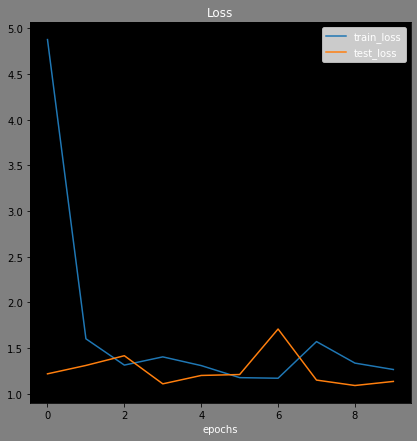

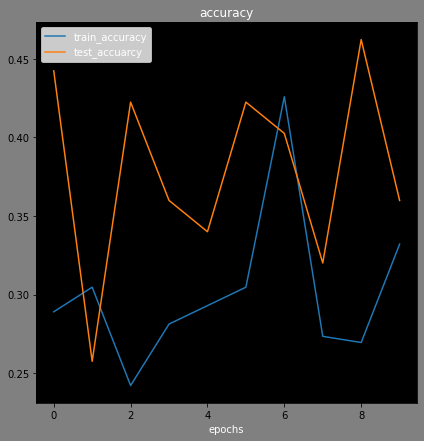

In [30]:
utils.plot_loss_curves(results)

Lets compare these results with a pre-trained version of the model from PyTorch.

### Get a pre-trained ViT model.


Luckily for us, the PyTorch library already comes with a pre-trained ViT model. 


Let's start by downloading the model and its weights and freezing its parameters. Tune the model to our specific task, create a ViT transformer, and load the data with a batch size of 32.
Now we can start fine-tuning the pre-trained ViT for our task.



In [57]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
utils.set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

pretrained_vit_transforms = pretrained_vit_weights.transforms()

BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=pretrained_vit_transforms,
    batch_size=BATCH_SIZE
)

Let us take a look at the summary

In [32]:
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=15,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224] [32, 3]         768             Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224] [32, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [32, 197, 768]  [32, 197, 768]  151,296         False
│    └─Dropout (dropout)                                     [32, 197, 768]  [32, 197, 768]  --              --
│    └─Sequential (layers)                                   [32, 197, 768]  [32, 197, 768]  --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]  [32, 197, 768]  (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]  [32, 197, 768]  (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 

### Comparing the two models
Before we train the pre-trained ViT for our specific task, let us compare the two models and see if they look alike.

In [60]:
summary(model=vit,
        input_size=(32, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=15,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
ViT (ViT)                                                    [32, 3, 224, 224] [32, 3]         152,064         True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224] [32, 196, 768]  --              True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224] [32, 768, 14, 14] 590,592         True
│    └─Flatten (flatten)                                     [32, 768, 14, 14] [32, 768, 196]  --              --
├─Dropout (embedding_dropout)                                [32, 197, 768]  [32, 197, 768]  --              --
├─Sequential (transformer_encoder)                           [32, 197, 768]  [32, 197, 768]  --              True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]  [32, 197, 768]  --              True
│    │    └─MultiheadSelfAttentionBlock (msa_block)          [32, 197, 768]  

When we examine these two summaries we can see that, while the presentation of the layers differs, the total number of parameters and the structure of the models remain the same.
also looks the same. So let's now try to train and test our pre-trained ViT model.



### Fine-tuning the pre-trained ViT model

In [61]:
from going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

utils.set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 |Train loss: 0.7663 |Train acc: 0.7188 |Test loss: 0.5210 |Test acc: 0.8968
Epoch: 2 |Train loss: 0.3467 |Train acc: 0.9414 |Test loss: 0.2671 |Test acc: 0.9583
Epoch: 3 |Train loss: 0.2308 |Train acc: 0.9492 |Test loss: 0.2084 |Test acc: 0.9176
Epoch: 4 |Train loss: 0.1544 |Train acc: 0.9648 |Test loss: 0.2274 |Test acc: 0.9176
Epoch: 5 |Train loss: 0.1329 |Train acc: 0.9648 |Test loss: 0.1601 |Test acc: 0.9583
Epoch: 6 |Train loss: 0.1136 |Train acc: 0.9766 |Test loss: 0.1526 |Test acc: 0.9583
Epoch: 7 |Train loss: 0.1466 |Train acc: 0.9766 |Test loss: 0.1624 |Test acc: 0.9384
Epoch: 8 |Train loss: 0.0837 |Train acc: 0.9805 |Test loss: 0.1650 |Test acc: 0.9176
Epoch: 9 |Train loss: 0.0837 |Train acc: 0.9805 |Test loss: 0.1538 |Test acc: 0.9375
Epoch: 10 |Train loss: 0.0687 |Train acc: 0.9883 |Test loss: 0.2205 |Test acc: 0.9176


<Figure size 1080x504 with 0 Axes>

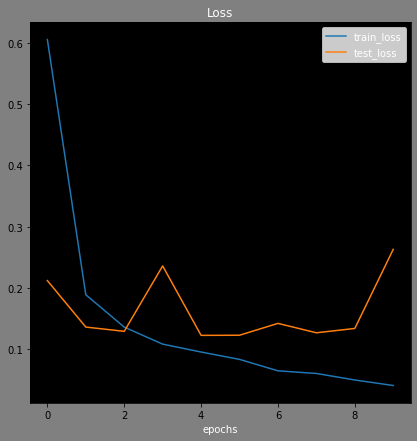

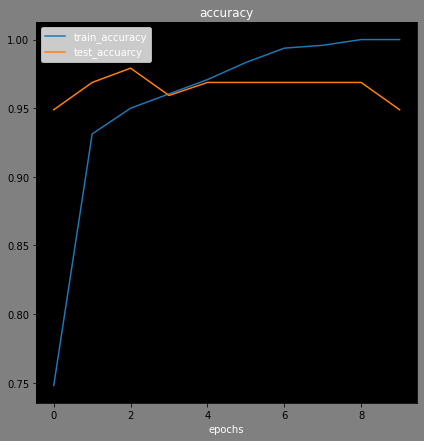

In [58]:
utils.plot_loss_curves(pretrained_vit_results)

### inspecting pre-trained ViT result
Wow! These results look a lot better than ours, even though the models had an almost identical structure. With a test loss of 0.2 and accuracy of 0.9, these are some decent results.

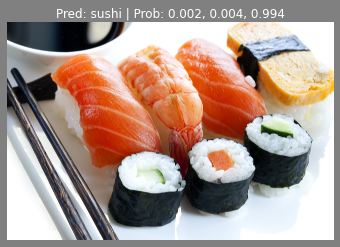

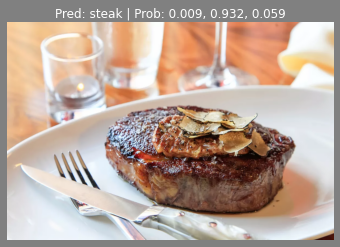

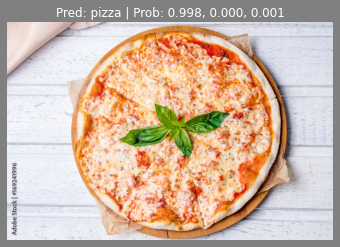

In [68]:
import requests

from going_modular import prediction

custom_image_path = image_path / 'img.jpg'

with open(custom_image_path, 'wb') as f:
    request = requests.get('https://www.wallpaperup.com/uploads/wallpapers/2015/06/14/722404/834827aa0c036d78c76719151c0f4234.jpg')
    f.write(request.content)
prediction.pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    image_size=(224,224),
                    class_names=class_names)

custom_image_path = image_path / 'img2.jpg'

with open(custom_image_path, 'wb') as f:
    request = requests.get('https://ca-times.brightspotcdn.com/dims4/default/63bac1d/2147483647/strip/true/crop/2048x1365+0+0/resize/1200x800!/format/webp/quality/80/?url=https%3A%2F%2Fcalifornia-times-brightspot.s3.amazonaws.com%2Fba%2Feb%2Fae74585f3319a538b0294f00fbb9%2Fpac-stk-restaurant-20180724-002')
    f.write(request.content)
prediction.pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    image_size=(224,224),
                    class_names=class_names)

custom_image_path = image_path / 'img2.jpg'

with open(custom_image_path, 'wb') as f:
    request = requests.get('https://as2.ftcdn.net/v2/jpg/01/69/24/19/1000_F_169241996_FVr0oG7RTO1u8do1GdYtfI0Ke5uDUt1a.jpg')
    f.write(request.content)
prediction.pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    image_size=(224,224),
                    class_names=class_names)


### Conclusions
Despite having a similar structure and the same number of parameters, our model and the pre-trained model perform very differently.


#### 1. The amount of training data
In our training process, we only used a subset of the food101 data set. Our dataset was built on around 300 images of pizza, steak, and sushi. 
If we compare the data set to the ones that the pre-trained ViT model has been trained on, we can see that their datasets contain about 14,000,000 images.
We also used a batch size of 32 compared to the ViT paper, which used a batch size of 4069. 
This could explain why our model was underfit but still became overfit after training for too long. Our dataset was too small to get 
a broad general sense of the data. If we trained it longer, it would have learned the features of the training data too well to generalize across different data.



#### 2. The amount of training time
When we trained our model, we only used 10 epochs, and more epochs in our case only led to overfitting.
The ViT paper states: "Finally, the ViT-L/16 model pre-trained on the public ImageNet-21k dataset performs well on
most datasets too, while taking fewer resources to pre-train: it could be trained using a standard cloud TPUv3 with 8 cores in approximately 30 days".


As we can see, they used a significantly longer training period than we did. To put things in perspective, renting a TPUv3 with 8 cores on
Google Cloud is eight dollars per hour. That means renting it for 30 days would cost $5,760 USD. 


### Summary
This tells us that ViT can be a state-of-the-art image classification model, but it's a large and memory-intensive model, and it takes a long time train. 
 


Self-attention in computer vision is far from optimized and, in many ways, still in its early stages.
There is still a lot of room for improvement by finding ways to optimize the self-attention architecture for computer vision tasks.
